
## Mini PJT.

- `titanic` competition

- 이번 프로젝트에서는 간단한 분류 문제를 풀어봅니다.

- sklearn으로 머신러닝 모델을 구현해봅니다.

- Machine Learning Workflow를 따라가봅니다.


Source : https://www.kaggle.com/c/titanic

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style="whitegrid")

### Load Data

In [1]:
# titanic data 불러오기
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')
submission= pd.read_csv('./data/titanic/gender_submission.csv')

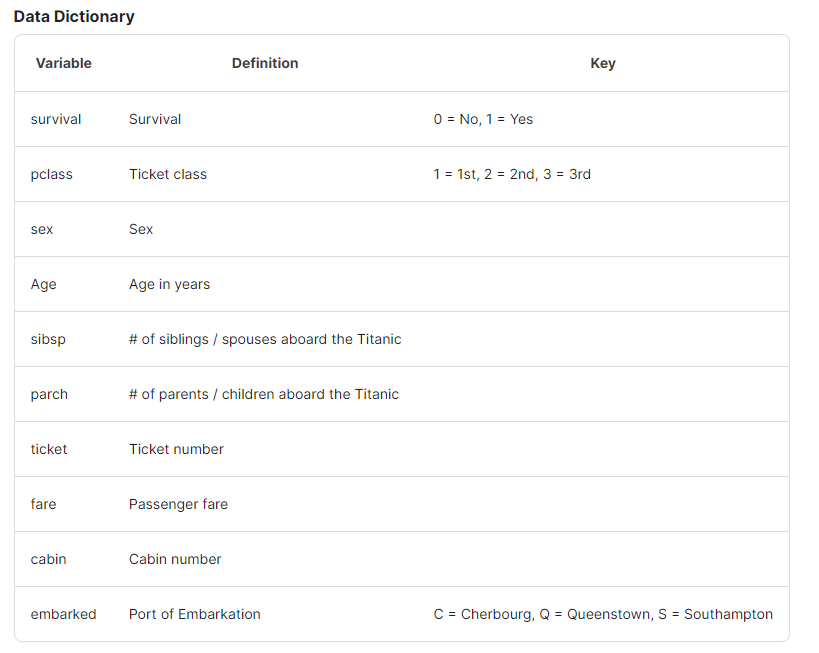

In [8]:
# 데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Preprocessing

1. 결측치 처리

2. feature selection (분석에 사용하지 않을 column 제거)

#### `Background`
1. 보트에는 여자와 아이들을 먼저 태우는 규정이 존재한다.
2. 각 Class 의 가격은 1912 년 당시 480만원(First), 190만원(Second), 48만원(Third)
    - 귀족은 배의 상선에서 파티를 즐겼다.
    - 귀족을 제외하고는 아래에 배치되어 있다.

c:\Users\hmk40\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


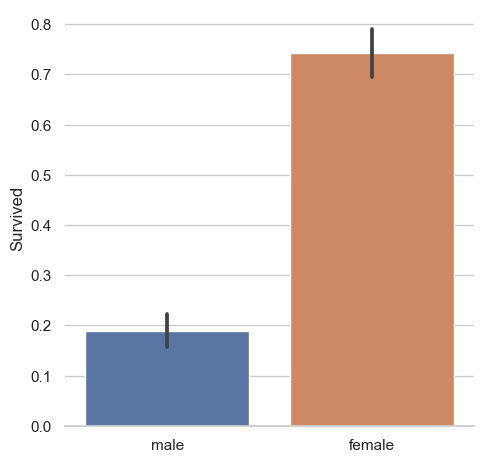

In [22]:
# Background 1 에 의해 여자와 아이들의 생존률이 높을 것이라고 생각할 수 있다.
g = sns.catplot(data=train, kind='bar', x='Sex', y='Survived')
g.despine(left=True)
g.set_axis_labels("", "Survived")


In [61]:
# 연령대에 따라서 생존률을 확인하고 싶지만, Age column 에 null data 가 존재한다.
# 해당 값을 채워주어야 한다.
# 영화에서 아이를 주로 먼저 태우고, 이후 성인 여성을 태웠다. 
# 이때, Miss 는 상대적으로 어린 여성이라고 할 수 있으므로 
# 모든 Age 를 평균으로 채우기 전, Miss 만 미리 따로 처리해준다.
# 그리고 Parch 가 있는 Miss 는 부모와 같이 동반한 어린 여성이라 할 수 있다.
####################################################################################

# 1. (Parch != 0) + Miss 인 그룹 구분
# 2. Miss 인 그룹
# 3. 나머지 
age_mean = train.Age.mean()
miss = train.loc[(train.Name.str.contains('Miss'))]
miss_mean = miss.Age.mean()
miss_parch_mean = miss.loc[miss['Parch'] != 0].Age.mean()

print(f'평균: {age_mean}')
print(f'Miss 평균: {miss_mean}')
print(f'부모 동반 Miss 평균: {miss_parch_mean}')

train.loc[(train.Name.str.contains('Miss')) & (train.Parch != 0) & (train['Age'].isna()), 'Age'] = round(miss_parch_mean, 0)
train.loc[(train.Name.str.contains('Miss')) & (train['Age'].isna()), 'Age'] = round(miss_mean, 0)
train.Age = train.Age.fillna(round(age_mean, 0))

평균: 29.69911764705882
Miss 평균: 21.773972602739725
부모 동반 Miss 평균: 11.863636363636363


C:\Users\hmk40\AppData\Local\Temp\ipykernel_10904\3042726255.py:7: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



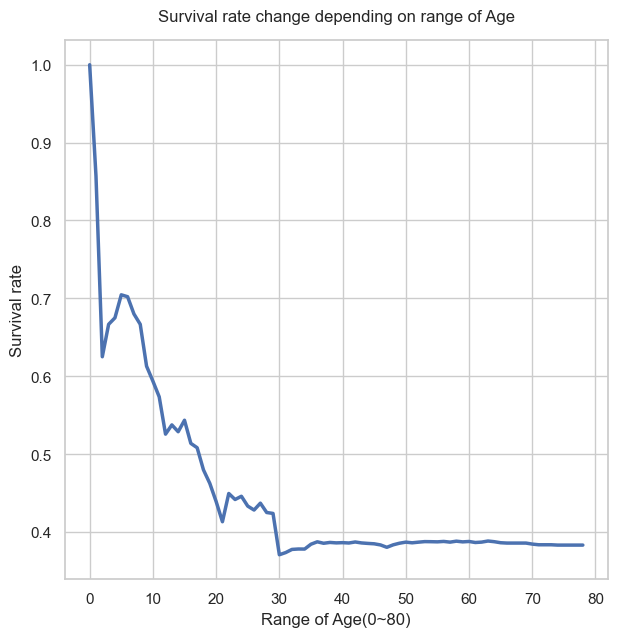

In [69]:
# 결측치를 채운 후 나이에 따른 생존률을 혹인해 보면,
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(train[train['Age'] < i]['Survived'].sum() / len(train[train['Age'] < i]['Survived']))
    
plt.figure(figsize=(7, 7))
sns.lineplot(cummulate_survival_ratio, palette='tab10', linewidth=2.5)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~80)')
plt.show()

#### `Remove` Features from Background
1. Embarked
    - port of embarkation 은 타이타닉호에 탑승하는 곳이다.
    - 타이타닉의 사고는 출항 후 사고가 났기 때문에 생존과 직결되지 않았을 것이다.

2. Cabin 
    - Cabin 은 객실을 의미한다.
    - 다만, 타이타닉은 주로 상선에서 파티를 때문에, Cabin 은 의미가 없을 것이다.

3. PassengerId
    - 의미없음
    - 프로래밍 상의 편의 (index 와 동일함)

4. Name
    - 결측치 처리 후, 이름에 따른 생존률도 의미없을 것이라 판단.

5. Ticket
    - 티켓은 Pclass로 대신할 수 있음

In [72]:
# 두 Column 을 지우겠습니다.
train = train.drop(columns=['Embarked', 'Cabin', 'PassengerId', 'Name', 'Ticket'])
train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,12.0,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


In [75]:
# 더이상의 결측치가 없는 것을 확인.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


### Feature Engineering

1. Categorical feature encoding

2. Normalization

In [76]:
# categorical feature --> One-hot Encoding
train_OHE = pd.get_dummies(train, columns=["Sex"])
train_OHE

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,False,True
1,1,1,38.0,1,0,71.2833,True,False
2,1,3,26.0,0,0,7.9250,True,False
3,1,1,35.0,1,0,53.1000,True,False
4,0,3,35.0,0,0,8.0500,False,True
...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,False,True
887,1,1,19.0,0,0,30.0000,True,False
888,0,3,12.0,1,2,23.4500,True,False
889,1,1,26.0,0,0,30.0000,False,True


In [80]:
# Normalization --> Min-Max scaling
X = train_OHE.drop(columns='Survived')
y = train_OHE.Survived

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# scaler.fit()
# scaler.transform()
# -> 한번에 
trans = scaler.fit_transform(X.loc[:, ['Age', 'Fare']])
X['Age'] = trans[:, 0]
X['Fare'] = trans[:, 1]
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,3,0.271174,1,0,0.014151,False,True
1,1,0.472229,1,0,0.139136,True,False
2,3,0.321438,0,0,0.015469,True,False
3,1,0.434531,1,0,0.103644,True,False
4,3,0.434531,0,0,0.015713,False,True
...,...,...,...,...,...,...,...
886,2,0.334004,0,0,0.025374,False,True
887,1,0.233476,0,0,0.058556,True,False
888,3,0.145514,1,2,0.045771,True,False
889,1,0.321438,0,0,0.058556,False,True


### Training 

In [81]:
# sklearn의 분류모델
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [82]:
clf = SGDClassifier()
clf2 = LogisticRegression()
clf3 = DecisionTreeClassifier()
clf4 = RandomForestClassifier()

clf.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
clf4.fit(X, y)

pred = clf.predict(X)
pred2 = clf2.predict(X)
pred3 = clf3.predict(X)
pred4 = clf4.predict(X)

In [83]:
print("1. Linear Classifier, Accuracy for training : %.4f" % accuracy_score(y, pred))
print("2. Logistic Regression, Accuracy for training : %.4f" % accuracy_score(y, pred2))
print("3. Decision Tree, Accuracy for training : %.4f" % accuracy_score(y, pred3))
print("4. Random Forest, Accuracy for training : %.4f" % accuracy_score(y, pred4))

1. Linear Classifier, Accuracy for training : 0.7957
2. Logistic Regression, Accuracy for training : 0.8058
3. Decision Tree, Accuracy for training : 0.9798
4. Random Forest, Accuracy for training : 0.9798


### Test (Predict)

In [89]:
test = pd.read_csv('./data/titanic/test.csv')

In [90]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [91]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [93]:
# test data에 같은 feature engineering을 적용해줍니다.
test.loc[(test.Name.str.contains('Miss')) & (test.Parch != 0) & (test['Age'].isna()), 'Age'] = round(miss_parch_mean, 0)
test.loc[(test.Name.str.contains('Miss')) & (test['Age'].isna()), 'Age'] = round(miss_mean, 0)
test.Age = test.Age.fillna(round(age_mean, 0))

In [94]:
test = test.drop(columns=['Embarked', 'Cabin', 'PassengerId', 'Name', 'Ticket'])

In [95]:
test_OHE = pd.get_dummies(data=test, columns=["Sex"])
temp = scaler.transform(test_OHE.loc[:, ["Age", "Fare"]])
test_OHE.Age = temp[:, 0]
test_OHE.Fare = temp[:, 1]

test_OHE

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,3,0.428248,0,0,0.015282,False,True
1,3,0.585323,1,0,0.013663,True,False
2,2,0.773813,0,0,0.018909,False,True
3,3,0.334004,0,0,0.016908,False,True
4,3,0.271174,1,1,0.023984,True,False
...,...,...,...,...,...,...,...
413,3,0.371701,0,0,0.015713,False,True
414,1,0.484795,0,0,0.212559,True,False
415,3,0.478512,0,0,0.014151,False,True
416,3,0.371701,0,0,0.015713,False,True


In [102]:
test_OHE = test_OHE.fillna(train.Fare.mean())

In [103]:
test_OHE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    bool   
 6   Sex_male    418 non-null    bool   
dtypes: bool(2), float64(2), int64(3)
memory usage: 17.3 KB


In [104]:
# prediction
result = clf.predict(test_OHE)
result2 = clf2.predict(test_OHE)
result3 = clf3.predict(test_OHE)
result4 = clf4.predict(test_OHE)

In [105]:
# 결과 파일인 submission.csv를 생성합니다.
submission["Survived"] = result4
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


- Kaggle 에 제출!

[제출하러가기] https://www.kaggle.com/c/titanic

In [108]:
submission.to_csv("./data/titanic/result_submission.csv", index=False)

## Second Try

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style="whitegrid")

In [2]:
# titanic data 불러오기
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')
submission= pd.read_csv('./data/titanic/gender_submission.csv')

In [4]:
# 1. 결측치 체크
# train.info()
# test.info()
# 2. dtype 이 Ojectr 인 column 찾기
train.columns[train.dtypes == 'object']
# 3. target value distribution 체크 ---> Class 별 비율 차이가 큰지 확인! (10:1 이상인지 확인)
train.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

##### Feature Engineering (데이터 가공)
- 머신러닝 모델링을 잘하는 기준이 되는 `데이터 가공`
- 데이터의 이해를 잘 한건지에 대한 기준이 된다.

1. `Cabin` Column

In [7]:
train.Cabin.info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
204 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


$\rightarrow$ Cabin column 의 결측치의 개수가 매우 많다.
- 결측치 여부가 Survived 에 영향이 있는가?

In [14]:
train.loc[train.Cabin.isnull(), 'Survived'].mean(), train.loc[train.Cabin.notnull(), 'Survived'].mean()

(0.29985443959243085, 0.6666666666666666)

$\rightarrow$ Cabin 의 유무에 따라 생존률이 유의미하게 나타났다 0.3 : 0.66 (2배 차이)
- `is_Cabin`Cabin 을 일일히 명명하는 것은 불가능하니, 유무에 따라 0과 1로 나타낸다.

In [22]:
train['is_Cabin'] = train.Cabin.notnull() * 1

In [23]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [24]:
train.is_Cabin.value_counts()

is_Cabin
0    687
1    204
Name: count, dtype: int64

2. `SibSp`, `Parch` -> Family

In [34]:
print(train.loc[train.SibSp == 0, 'Survived'].mean(), train.loc[train.SibSp != 0, 'Survived'].mean())
print(train.loc[train.Parch == 0, 'Survived'].mean(), train.loc[train.Parch != 0, 'Survived'].mean())

0.34539473684210525 0.4664310954063604
0.34365781710914456 0.5117370892018779


$\rightarrow$ 가족이 있는 유무에 따라서 생존률이 다르며, 그 비율은 비슷하게 나타남. FamilySize column 으로 합산

In [31]:
train['FamilySize'] = train['SibSp'] + train['Parch']

3. Drop columns

- `Name`: Mr, Mrs, Miss 등으로 성별 및 결혼 유무를 구분할 수 있음.
    - 성별은 이미 나와있음.
    - 결혼 유무는 나이 및 FamilySize 에 어느 정도 나와있을 것이라 추론함.
- `Ticket`: 티켓이름으로 어떠한 연관성도 파악할 수 없음
    - Ticket 에 대한 정보는 `Pclass` 로 추론가능

In [36]:
drop_cols = ['Cabin', 'SibSp', 'Parch', 'PassengerId', 'Name', 'Ticket']
train = train.drop(columns=drop_cols)
train

,Survived,Pclass,Sex,Age,Fare,Embarked,is_Cabin,FamilySize
0,0,3,male,22.0,7.2500,S,0,1
1,1,1,female,38.0,71.2833,C,1,1
2,1,3,female,26.0,7.9250,S,0,0
3,1,1,female,35.0,53.1000,S,1,1
4,0,3,male,35.0,8.0500,S,0,0
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,0,0
887,1,1,female,19.0,30.0000,S,1,0
888,0,3,female,NaN,23.4500,S,0,3
889,1,1,male,26.0,30.0000,C,1,0


4. Nan row 처리

In [40]:
train.Age = train.Age.fillna(train.Age.median())
train = train.dropna()

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Sex         889 non-null    object 
 3   Age         889 non-null    float64
 4   Fare        889 non-null    float64
 5   Embarked    889 non-null    object 
 6   is_Cabin    889 non-null    int32  
 7   FamilySize  889 non-null    int64  
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 59.0+ KB


5. Encoding categorical feature (`One-hot encoding`)

In [45]:
train = pd.get_dummies(data=train, columns=['Sex', 'Embarked'])
train

,Survived,Pclass,Age,Fare,is_Cabin,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,0,1,False,True,False,False,True
1,1,1,38.0,71.2833,1,1,True,False,True,False,False
2,1,3,26.0,7.9250,0,0,True,False,False,False,True
3,1,1,35.0,53.1000,1,1,True,False,False,False,True
4,0,3,35.0,8.0500,0,0,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,0,0,False,True,False,False,True
887,1,1,19.0,30.0000,1,0,True,False,False,False,True
888,0,3,28.0,23.4500,0,3,True,False,False,False,True
889,1,1,26.0,30.0000,1,0,False,True,True,False,False


In [49]:
from sklearn.model_selection import train_test_split
X = train.drop(columns='Survived')
y = train.Survived

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(711, 10) (178, 10) (711,) (178,)


#### Training

In [50]:
from sklearn.linear_model import SGDClassifier      # Linear Classifier
from sklearn.tree import DecisionTreeClassifier     # CART
from sklearn.ensemble import RandomForestClassifier 

clf1 = SGDClassifier()
clf2 = DecisionTreeClassifier()
clf3 = RandomForestClassifier()
# random state 를 정하지 않으면 성능이 바뀜.

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, clf1.predict(X_train))) # underfitting
print("Train ACC: %.4f" % accuracy_score(y_train, clf2.predict(X_train)))
print("Validation ACC: %.4f" % accuracy_score(y_val, clf2.predict(X_val)))

print("Train ACC: %.4f" % accuracy_score(y_train, clf3.predict(X_train)))
print("Validation ACC: %.4f" % accuracy_score(y_val, clf3.predict(X_val)))

0.5907172995780591
Train ACC: 0.9887
Validation ACC: 0.7697
Train ACC: 0.9887
Validation ACC: 0.8146


In [56]:
# 성능이 좋은 Random Forest 사용
clf = RandomForestClassifier(max_depth=7,
                             n_estimators=100,
                             max_features=0.8,
                             min_samples_split=5,
                             random_state=42)
clf.fit(X_train, y_train)
print("Train ACC: %.4f" % accuracy_score(y_train, clf.predict(X_train)))
print("Validation ACC: %.4f" % accuracy_score(y_val, clf.predict(X_val)))

Train ACC: 0.9086
Validation ACC: 0.8258


In [ ]:
train['is_Cabin'] = train.Cabin.notnull() * 1
train['FamilySize'] = train['SibSp'] + train['Parch']
drop_cols = ['Cabin', 'SibSp', 'Parch', 'PassengerId', 'Name', 'Ticket']
train = train.drop(columns=drop_cols)
train
train.Age = train.Age.fillna(train.Age.median())
train = train.dropna()
train = pd.get_dummies(data=train, columns=['Sex', 'Embarked'])
train

In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [ ]:
test['is_Cabin'] = test.Cabin.notnull() * 1
test['FamilySize'] = test['SibSp'] + test['Parch']
drop_cols = ['Cabin', 'SibSp', 'Parch', 'PassengerId', 'Name', 'Ticket']
test = test.drop(columns=drop_cols)
test.Age = test.Age.fillna(train.Age.median())
test = test.dropna()

In [60]:
test = pd.get_dummies(data=test, columns=['Sex', 'Embarked'])
test

,Pclass,Age,Fare,is_Cabin,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,7.8292,0,0,False,True,False,True,False
1,3,47.0,7.0000,0,1,True,False,False,False,True
2,2,62.0,9.6875,0,0,False,True,False,True,False
3,3,27.0,8.6625,0,0,False,True,False,False,True
4,3,22.0,12.2875,0,2,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
413,3,28.0,8.0500,0,0,False,True,False,False,True
414,1,39.0,108.9000,1,0,True,False,True,False,False
415,3,38.5,7.2500,0,0,False,True,False,False,True
416,3,28.0,8.0500,0,0,False,True,False,False,True


In [61]:
clf.predict(test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,